In [1]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from matplotlib.colors import LinearSegmentedColormap
import glob
import os
from PIL import Image
# twinLab import
import twinlab as tl
tl.set_user("cyd@digilab.co.uk")
tl.set_api_key("tl_oA4GuDIS9j6MIXEu502IdA")




          ====== TwinLab Client Initialisation ======
          Version     : 2.21.0
          User        : cyd@digilab.co.uk
          Server      : https://twinlab.digilab.co.uk/v3
          Environment : /Users/cyd/Desktop/twinLab/.env



In [2]:
constant = 1E9

In [3]:
def create_gif(input_folder, output_path, duration=200, loop=0):
    """
    Create a GIF from a folder of images.

    Args:
        input_folder (str): Path to the folder containing images.
        output_path (str): Path to save the output GIF.
        duration (int): Duration between frames in milliseconds.
        loop (int): Number of times the GIF should loop (0 = infinite).
    """
    # Collect all images (common formats)
    image_files = sorted(
        glob.glob(os.path.join(input_folder, "*.png")) +
        glob.glob(os.path.join(input_folder, "*.jpg")) +
        glob.glob(os.path.join(input_folder, "*.jpeg"))
    )

    if not image_files:
        raise ValueError("No images found in the specified folder.")

    # Open images
    images = [Image.open(img).convert("RGBA") for img in image_files]

    # Save as GIF
    images[0].save(
        output_path,
        save_all=True,
        append_images=images[1:],
        duration=duration,
        loop=loop
    )

    print(f"GIF saved at {output_path}")

In [ ]:
def run_loop():
    MEANS = []
    UNCERTANTIES = []
    # read the training data from galaxy workflows
    df = pd.read_csv("Data//tmap-active-loop_training_data.csv")


    giflen = 10
    df_total = pd.DataFrame({
        "solubility": df["solubility"][:],
        "diffusivity":constant*(df["diffusivity"][:]),
        "thickness": df["thickness"][:],
        "output_flow":df["output_flow"][:]


    })
    for i in range(giflen):
        df_input = pd.DataFrame({
        "solubility": df["solubility"][:5*i+4],
        "diffusivity":constant*(df["diffusivity"][:5*i+4]),
        "thickness": df["thickness"][:5*i+4],
        "output_flow":df["output_flow"][:5*i+4]
    })
        

        # Define the name of the dataset
        dataset_id = "UoM_dataset"+str(i)

        # Intialise a Dataset object
        dataset = tl.Dataset(id=dataset_id)

        # Upload the dataset
        dataset.upload(df_input, verbose=True)


        # Initialise emulator
        emulator_id = "UoM_emulator"+str(i)
        emulator = tl.Emulator(id=emulator_id)

        # Define the training parameters for your emulator
        output_columns = ["output_flow"]
        params = tl.TrainParams(
            train_test_ratio=0.7,
            estimator="gaussian_process_regression",

        )

        # Train the emulator using the train method
        emulator.train(
            dataset=dataset,
            inputs=["diffusivity","solubility","thickness"],
            outputs=output_columns,
            params=params,
            verbose=True,
        )

        # create grid for plotting predictions
        npoints = 500

        X, Y = np.meshgrid(np.linspace(np.min(df_total["diffusivity"]),np.max(df_total["diffusivity"]),npoints),
                            np.linspace(np.min(df_total["solubility"]),np.max(df_total["solubility"]),npoints))
        OUTPUT = X.copy()*0+np.mean(df_total["thickness"])
        df_test = pd.DataFrame({
            "diffusivity": X.flatten(),
            "solubility": Y.flatten(),
            "thickness": OUTPUT.flatten(),
        })
        scoreparams = tl.ScoreParams(metric="MSLL")
        print("validation_msll",emulator.score(params=scoreparams))
        scoreparams = tl.ScoreParams(metric="R2")
        print("validation_R2",emulator.score(params=scoreparams))
        # predict on the input grid
        df_pred,df_std = emulator.predict(df_test)
        # plot the outputs of the emulator

        MEANS.append(np.array(df_pred["output_flow"]).reshape(npoints,npoints))
        UNCERTANTIES.append(np.array(df_std["output_flow"]).reshape(npoints,npoints))
    return np.array(MEANS),np.array(UNCERTANTIES), X, Y ,Z


MEANS,UNCERTAINTIES,X,Y,Z=run_loop()


Dataframe is uploading.
Dataset successfully uploaded.
Emulator 'UoM_emulator0' has begun training.
0:00:00: Job status: processing
0:00:02: Job status: processing
0:00:04: Job status: processing
0:00:07: Job status: processing
0:00:09: Job status: processing
0:00:12: Job status: success
Training of emulator UoM_emulator0 is complete!
validation_msll    output_flow
0     0.002121
validation_R2    output_flow
0  -225.750717
Job predict process ID: predict-grove-diagnostic-cattle
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:05: Job status: processing
0:00:07: Job status: processing
0:00:10: Job status: processing
0:00:13: Job status: success
Mean predictions:
        output_flow
0          8.532410
1          8.532410
2          8.532410
3          8.532410
4          8.532410
...             ...
249995     8.533216
249996     8.533213
249997     8.533211
249998     8.533208
249999     8.533206

[250000 rows x 1 columns]
Standard de

NameError: name 'Z' is not defined

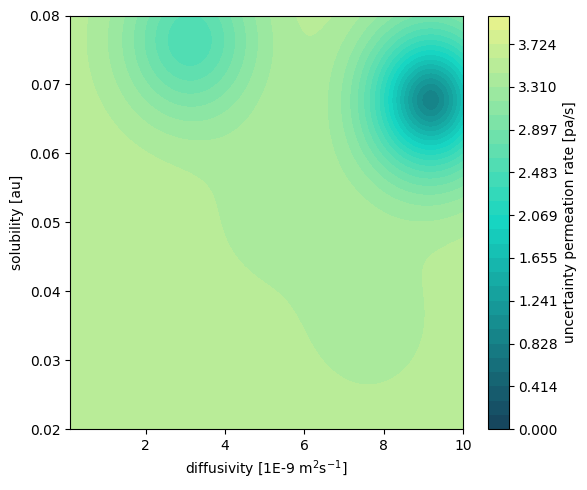

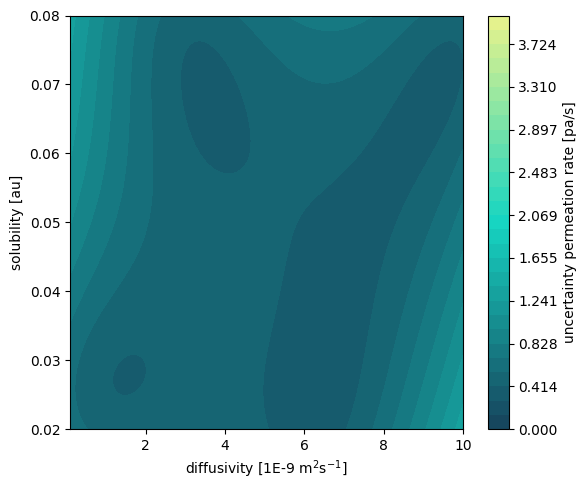

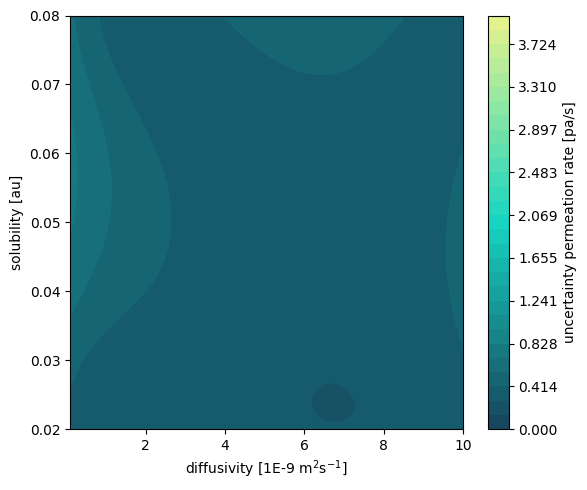

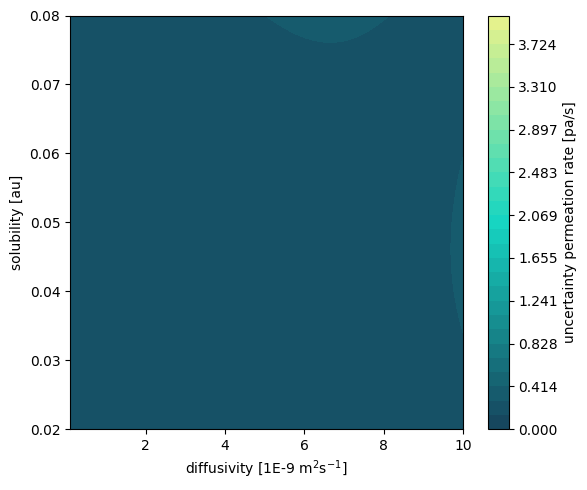

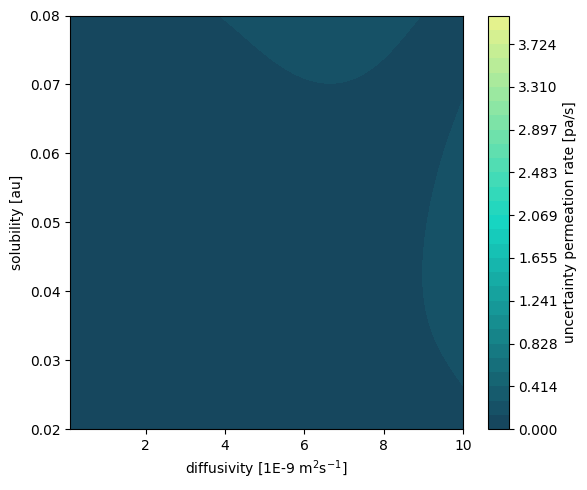

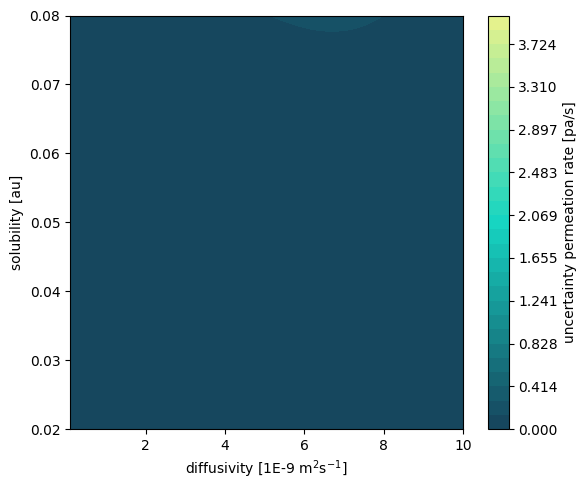

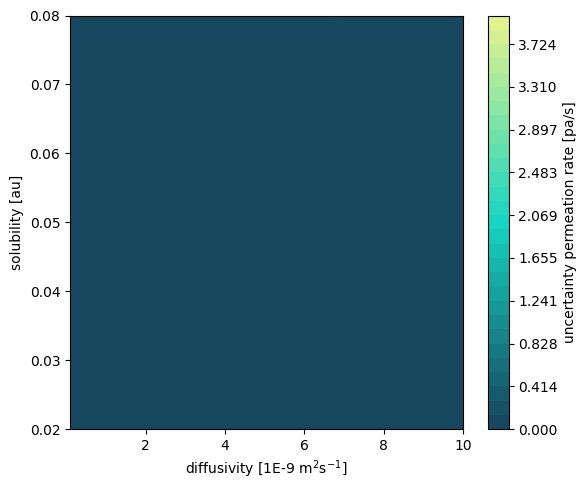

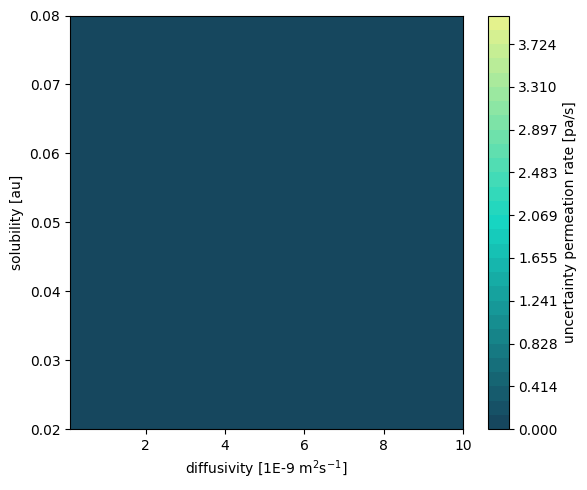

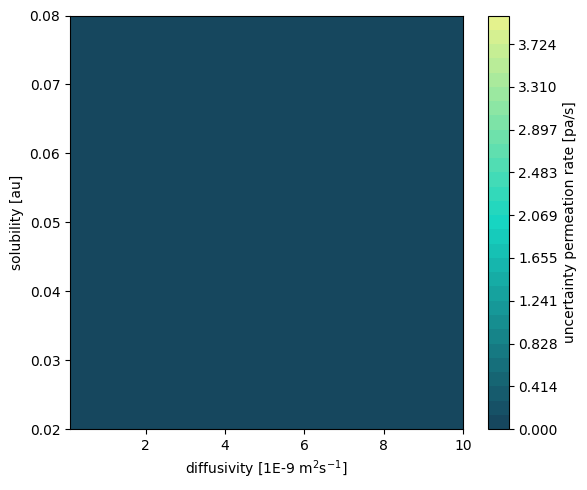

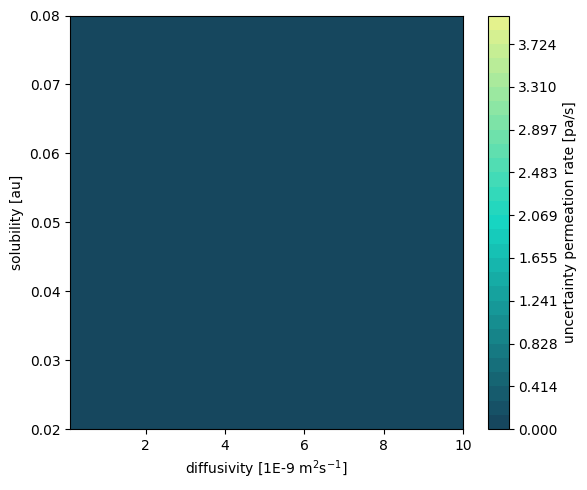

In [87]:
def plot_looped_data(DATA,mode,X,Y,Z):
    colors = ["#16425B","#16D5C2","#EBF38B"]
    for i in range(len(DATA)):
        emulator_id = "UoM_emulator"+str(i)
        emulator = tl.Emulator(id=emulator_id)
        df_train = emulator.view_train_data()
        # plot the tritium permeation rate
        fig = plt.figure(figsize=(6, 5))
        if mode == "3d":
            ax = fig.add_subplot(111, projection='3d')


        custom_cmap = LinearSegmentedColormap.from_list("bah", colors) 
        OUTPUT = DATA[i]
        vmin = 0
        vmax = 0
        levels = 0
        if mode == "mean":
            # vmin = 0.05
            vmax = 16
            levels = np.linspace(vmin, vmax, 15) 
        else:
            vmax = 4

            levels = np.linspace(vmin, vmax, 50)
            # levels = np.append(levels,4) 


        if mode == "mean":
            contour = plt.contourf(X, (Y), OUTPUT, levels=levels, cmap=custom_cmap)  # filled contours
            # contour.set_clim(vmin,vmax)
            cbar = plt.colorbar(contour,label="permeation rate [pa/s]")
            plt.xlabel("diffusivity [1E-9 m"+r"$^{2}$"+"s"+r"$^{-1}$"+"]")
        elif mode == "uncertainty":
            contour = plt.contourf(X, (Y), OUTPUT, levels=levels, cmap=custom_cmap)  # filled contours
            # contour.set_clim(vmin,vmax)
            cbar = plt.colorbar(contour,label="uncertainty permeation rate [pa/s]")
            plt.xlabel("diffusivity [1E-9 m"+r"$^{2}$"+"s"+r"$^{-1}$"+"]")
        else:
            scatter = ax.scatter(df_train["thickness"], df_train["solubility"], df_train["diffusivity"], color="black", cmap='viridis')
            print(np.max(df_train["diffusivity"]))
            # ax.set_axis_off()
            plt.xlim([1.9,2])
            ax.set_xlabel("thickness [mm]")
            ax.set_zlabel("diffusivity [1E-9 m"+r"$^{2}$"+"s"+r"$^{-1}$"+"]")
            plt.ylim([0.02,0.1])
            ax.set_zlim([0,10])
            ax.grid(False)
        # if mode != "3d":
            # cbar.set_clim(vmin, vmax)
            # cs = plt.contour(X, Y, OUTPUT, levels=[0.72], colors="red")
        # plt.scatter(df_train["diffusivity"],df_train["solubility"],color="black")
        
        plt.ylabel("solubility [au]")
        plt.tight_layout()
        plt.savefig("Figures_"+mode+"/output"+str(i)+".png",dpi=300,transparent=True)
        plt.show()
# plot_looped_data(MEANS,"mean",X,Y,Z)
plot_looped_data(UNCERTAINTIES,"uncertainty",X,Y,Z)
# plot_looped_data(MEANS,"3d",X,Y,Z)

In [79]:
create_gif("Figures_mean","mean.gif",duration=800)

GIF saved at mean.gif


In [80]:
create_gif("Figures_uncertainty","uncertainty.gif",duration=800)

GIF saved at uncertainty.gif


In [83]:
create_gif("Figures_3d","3d.gif",duration=800)

GIF saved at 3d.gif
